# Comparing threading and multiprocessing

In [1]:
import time

import multiprocessing as mp
from multiprocessing import Pool as ProcessPool
from multiprocessing.pool import ThreadPool

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_context('talk')

## Introduction

There are various choices when trying to run code in parallel.

The `threading` module will run all threads on the same CPU core which requires less overhead and allows for more efficient sharing of memory. However, it is not truly parallel and executes the threads when others are idling.

The `multiprocessing` module runs the processes on multiple CPU cores and can thus execute code at the same time.

## Preparations

To investigate the differences between threading and multiprocessing,
we will simulate work for each data point and measure when it was executed.

Due to some [design choices](https://bugs.python.org/issue25053), we have to import the worker function from a separate module for the `ProcessPool` to work.

In [3]:
%%writefile worker.py

import time


def worker(data):
    tmp = []
    for i in data:
        # simulate CPU load
        for _ in range(1_000_000):
            pass

        # store execution time
        tmp.append(time.time())
    return tmp 

Overwriting worker.py


In [4]:
from worker import worker

In [5]:
data = list(range(20))
num = mp.cpu_count()

## Computations

We run the `worker` function on the dataset for each executor in both the process and thread pool.

In [6]:
%%time
with ThreadPool(num) as p:
    thread_result = p.map(worker, [data] * num)

CPU times: user 3.79 s, sys: 131 ms, total: 3.92 s
Wall time: 3.86 s


In [7]:
%%time
with ProcessPool(num) as p:
    process_result = p.map(worker, [data] * num)

CPU times: user 26 ms, sys: 56.7 ms, total: 82.7 ms
Wall time: 1.4 s


Next, we store the result in a dataframe.

In [8]:
df_thread = pd.melt(
    pd.DataFrame(thread_result, index=[f'job {i:2}' for i in range(num)]).T
)
df_thread['type'] = 'thread'

df_process = pd.melt(
    pd.DataFrame(process_result, index=[f'job {i:2}' for i in range(num)]).T
)
df_process['type'] = 'process'

df = pd.concat([df_thread, df_process], ignore_index=True)
df['value'] = df.groupby('type')['value'].apply(lambda x: x - x.min())  # normalize time
df.head()

,variable,value,type
0,job 0,0.105189,thread
1,job 0,0.316431,thread
2,job 0,0.592710,thread
3,job 0,0.704985,thread
4,job 0,0.822085,thread


## Investigation

There are two main observations:

* `multiprocessing` execution takes less total runtime than `threading`

* `multiprocessing` timestamps are in parallel, while `threading` timestamps are serial

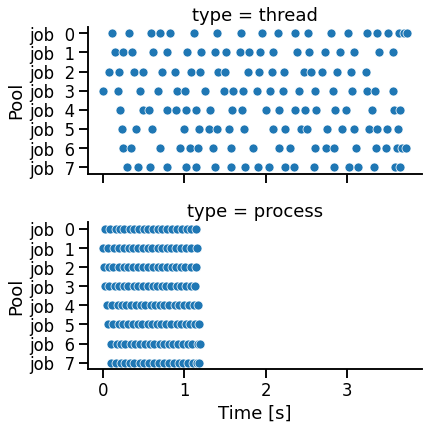

In [9]:
g = sns.FacetGrid(df, row='type', aspect=2)
g.map_dataframe(sns.scatterplot, x='value', y='variable')
g.set_axis_labels('Time [s]', 'Pool')

The decision whether to use threading or multiprocessing depends on the use case.

As a general rule of thumb, one should use threading if the problem is IO bound and multiprocessing if it is CPU bound.